# Verify the sensor sensitivity
- We build two models here":
- A. model with 6 snesors, removing 10 top low sensitive sensors.  sensor names: [10, 11, 12, 13, 5, 14, 6, 8, 2, 7], not the columns!
- B. model with 6 snesors, removing 10 top high sensitive sensors. sensor names: [15,  1,  4, 16, 3, 9, 7, 2, 8, 6], not the columns!
- This code, we only focus on $t^*=[0,1]$

# Prepare data

Define the task complete.
(80000, 18)
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
(32,)
['case_13', 'case_20', 'case_25', 'case_28']
Done!
Done
Done!


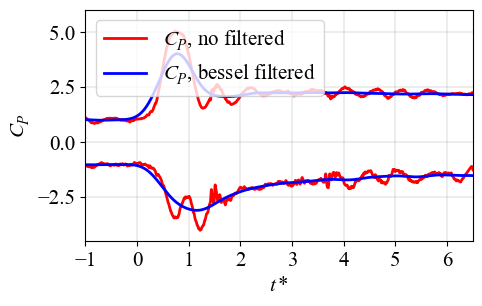

In [1]:
import tensorflow as tf
from tensorflow.keras import optimizers, Sequential, regularizers
from tensorflow.keras.layers import Dense, Input

task = 'predict' 
force = 'CL'     
filt = 'bessel' 
ensemble_num = 30

if task == 'cross_validation':
    folds = 7
elif task == 'predict':
    folds = 1
else:
    print('Error. Please define your task.') 
print('Define the task complete.')

# Set the font family to Times New Roman
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 15

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'

from keras import backend as K
import numpy as np  #Mathmatical library
import pandas as pd #for data load

import matplotlib.pyplot as plt #Plot
from tqdm import tqdm as tqdm
from scipy.signal import bessel
from scipy.signal import filtfilt

# initialize the data
history_all = {}
predictions_A = {}
predictions_B = {}

# folder path

data_path = '../train_dataframe/gust_dataframe.csv'

# read the excel data
gust_origin = pd.read_csv(data_path)

# set the first column as index, i.e. set case_nn as index, for convenience
gust_origin.set_index('case_number', inplace=True)
print(gust_origin.shape)
# check the first 5 columns
gust_origin.head()

# bessel filter for every column; only filt CP
if filt == 'bessel':
    
    gust_index   = gust_origin.index
    gust_column  = gust_origin.columns
    gust_no_filter = np.zeros((len(set(gust_index.to_list())),len(gust_origin.loc[['case_01']]),len(gust_origin.columns))) # (32,2500,18)
    gust_filter    = np.zeros((len(set(gust_index.to_list())),len(gust_origin.loc[['case_01']]),len(gust_origin.columns)))
    case_all_no = (np.linspace(0,31,32)).astype(int)
    b, a = bessel(8, 0.01) # define the bessel filter; 8 is the filter order; 0.01 is the W_n (between 0 to 1)
    
    for i in case_all_no:      # i is the case number
        case_numer = 'case_' + str(i+1).zfill(2)
        gust_no_filter[i] = gust_origin.loc[[case_numer]].to_numpy()
        for j in range(len(gust_origin.columns)-2):       # j is the CP and CL CD number
            gust_filter[i][:,j] = filtfilt(b, a, gust_no_filter[i][:,j])  # bessel for CP
        gust_filter[i][:,len(gust_origin.columns)-2] = gust_no_filter[i][:,len(gust_origin.columns)-2]  # no filter for CL
        gust_filter[i][:,len(gust_origin.columns)-1] = gust_no_filter[i][:,len(gust_origin.columns)-1]  # no filter for CD
    gust = pd.DataFrame(data=np.concatenate(gust_filter,axis=0), index=gust_index, columns=gust_column)
    
elif filt == 'no filter':
    gust = gust_origin
    
else:
    print('Error. Please define your filter.')

# check filter result

T = 0.3 # period is 0.3s
f = 1000 # frequency is 1000Hz
t_star = (np.arange(0,10000) - 500) / f / T

if filt == 'bessel':
    ii = 13 # case to show
    case_to_show = 'case_' + str(ii).zfill(2)
    cp_to_show   = [-3,-4] # -3 is p0 (stagnation point), -4 is p16(training edge point)
    fig,ax = plt.subplots(figsize=(5,3))
    ax.plot(t_star[0:2500],gust_origin.loc[[case_to_show]].to_numpy()[:,cp_to_show[0]],label='$C_{P}$, no filtered', color='red', linewidth=2)
    ax.plot(t_star[0:2500],gust_origin.loc[[case_to_show]].to_numpy()[:,cp_to_show[1]], color='red', linewidth=2)
    ax.plot(t_star[0:2500],gust.loc[[case_to_show]].to_numpy()[:,cp_to_show[0]],label='$C_{P}$, bessel filtered', color='b', linewidth=2)
    ax.plot(t_star[0:2500],gust.loc[[case_to_show]].to_numpy()[:,cp_to_show[1]], color='b', linewidth=2)
    ax.legend()
    ax.margins(x=0)
    ax.set_xlabel('$t*$')
    ax.set_xticks(np.arange(-1,8))
    ax.set_xlim(-1,6.5)
    ax.set_ylabel('$C_{P}$')
    ax.set_ylim(-4.5,6)
    ax.grid(color='k', linestyle='-', linewidth=0.1)
    
elif filt == 'no filter':
    print('No filter. No compare.')
else:
    print('Error. Please define your filter.')

# fig.savefig('CP_Filter_case_%d_port%d.png' % (ii,0), bbox_inches='tight', dpi=300)
# fig.savefig('CP_Filter_case_%d_port%d.svg' % (ii,0), bbox_inches='tight')

# retrieve CP, 16(CP) + 16(CP_1st_order) + 16(CP_2nd_order) = 48 columns in total
# simply drop CL and CD, then the rest is CP
CP = gust.drop(['CL','CD'],axis=1, inplace=False)
CP.head()

# retrieve CL and CD
CL = gust[['CL']]
CD = gust[['CD']]
gust[[force]].head()

# retrieve for 8 different folds
# read the split .txt file; the number means the cases for test
split_path = '../train_dataframe/delta_wing_32cases_split_random.txt'
with open(split_path, 'r') as file1:    
    fold_split = file1.read().splitlines()       # split by \n
fold_split = fold_split[1:] # drop the head line
for i in range(8):
    fold_split[i] = fold_split[i][9:].split()    # split by space; the number starts from 10th character.
    for j in range(4):
        fold_split[i][j] = int(fold_split[i][j]) # convert string to int
fold_split

# define the 32 case number
case_all_num = np.arange(gust.index.nunique()) + 1
print(case_all_num)
print(case_all_num.shape)

# find the case number for train and test cases;
if task == 'cross_validation':
    train_case = [ [0]*24 for _ in range(folds) ] # initialize 2d list; list for 'case_nn'
    test_case  = [ [0]*4 for _ in range(folds) ]
    # find case number for cross validation folds: fold1~fold7
    for i in range(folds): 
        train_case_temp = np.setdiff1d( case_all_num, np.concatenate((fold_split[i], fold_split[-1]))) 
        # drop test case and the last one (which is for fold 8 , final test)
        test_case_temp  = fold_split[i]

        # conbine to 'case_nn' sample for train and test case; prepare for next step
        for j in range(len(train_case_temp)):
            train_case[i][j] = 'case_' + str(train_case_temp[j]).zfill(2)
        for k in range(len(test_case_temp)):
            test_case[i][k]  = 'case_' + str(test_case_temp[k]).zfill(2)
            
elif task == 'predict': 
    train_case = [ [0]*28 for _ in range(folds) ] # initialize 2d list; list for 'case_nn'
    test_case  = [ [0]*4 for _ in range(folds) ]
    # find case number for test fold: fold8  
    train_case_temp = np.setdiff1d(case_all_num, fold_split[-1])
    test_case_temp  = fold_split[-1]
    for jj in range(len(train_case_temp)):
        train_case[-1][jj] = 'case_' + str(train_case_temp[jj]).zfill(2)
    for kk in range(len(test_case_temp)):
        test_case[-1][kk]  = 'case_' + str(test_case_temp[kk]).zfill(2)

else:
    print('Error. Please define your task.')

print(test_case[0])
print('Done!')

#  prepare for train and test data sets
if task == 'cross_validation':
    F_train_rec = np.zeros([folds,60000,1]) # 24*2500 = 60000
    F_test_rec  = np.zeros([folds,10000,1])  # 4*2500  = 10000
    P_train_rec = np.zeros([folds,60000,48])
    P_test_rec  = np.zeros([folds,10000,48])

    for i in range(folds): # 7 folds for training, the last one is for test, not retrieve here, since this is for training
        if force == 'CL':
            F_train_rec[i] = CL.loc[train_case[i]].to_numpy()
            F_test_rec[i]  = CL.loc[test_case[i]].to_numpy()
        elif force == 'CD':
            F_train_rec[i] = CD.loc[train_case[i]].to_numpy()
            F_test_rec[i]  = CD.loc[test_case[i]].to_numpy()
        else:
            print('Error. Please define force.')

        P_train_rec[i] = CP.loc[train_case[i]].to_numpy()
        P_test_rec[i]  = CP.loc[test_case[i]].to_numpy()

elif task == 'predict':
    F_train_rec = np.zeros([folds,70000,1]) # 28*2500 = 70000
    F_test_rec  = np.zeros([folds,10000,1])  # 4*2500  = 10000
    P_train_rec = np.zeros([folds,70000,16])
    P_test_rec  = np.zeros([folds,10000,16])
    
    if force == 'CL':
        F_train_rec[0] = CL.loc[train_case[0]].to_numpy()
        F_test_rec[0]  = CL.loc[test_case[0]].to_numpy()
    elif force == 'CD':
        F_train_rec[0] = CD.loc[train_case[0]].to_numpy()
        F_test_rec[0]  = CD.loc[test_case[0]].to_numpy()
    else:
        print('Error. Please define force.')

    P_train_rec[0] = CP.loc[train_case[0]].to_numpy()
    P_test_rec[0]  = CP.loc[test_case[0]].to_numpy()
    
else:
    print('Error. Please define your task.')
    
print('Done')

F_train = F_train_rec[0][:,:]   # change to 2d for training
F_test  = F_test_rec[0][:,:]
P_train = P_train_rec[0][:,:]
P_test  = P_test_rec[0][:,:]

print('Done!')

# extract the data, so that only 10 sensors are used for train and test
- We build two models here"?
- A. model with 6 snesors, removing 10 top low sensitive sensors.  sensor names: [10, 11, 12, 13, 5, 14, 6, 8, 2, 7], not the columns!
- B. model with 6 snesors, removing 10 top high sensitive sensors. sensor names: [15,  1,  4, 16, 3, 9, 7, 2, 8, 6], not the columns!

## Prepare data for model A

In [2]:
# exclude sensor 10, 11, 12, 13, 5, 14, 6, 8, 2, 7
exclude_sensor_A = [10, 11, 12, 13, 5, 14, 6, 8, 2, 7]
exclude_sensor_A = [x - 1 for x in exclude_sensor_A]
F_train_A = F_train[:,:]   
F_test_A  = F_test[:,:]
P_train_A = np.delete(P_train, exclude_sensor_A, axis=1) 
P_test_A  = np.delete(P_test, exclude_sensor_A, axis=1)
print(exclude_sensor_A)

[9, 10, 11, 12, 4, 13, 5, 7, 1, 6]


## Prepare data for model B

In [3]:
# exclude sensor 15,  1,  4, 16, 3, 9, 7, 2, 8, 6
columns_to_exclude = [15,  1,  4, 16, 3, 9, 7, 2, 8, 6]
columns_to_exclude = [x - 1 for x in columns_to_exclude]
P_train_B = np.delete(P_train, columns_to_exclude, axis=1)
P_test_B = np.delete(P_test, columns_to_exclude, axis=1)
F_train_B = F_train
F_test_B = F_test
print(columns_to_exclude)

[14, 0, 3, 15, 2, 8, 6, 1, 7, 5]


# Begin training

In [4]:
''' begin training '''

from keras.models import load_model
from keras.layers import PReLU 
import datetime
import time

num_neuron = [72]#[16, 24, 32, 40, 48, 56, 64, 72]
num_layer  = [8]#[1,2,3,4,5,6,7,8]
epoch_total = 200 # 200 #l1_n8:193; l1_n16:196; l1_n24:189; l1_n32:166
weight_decay = 0 # 5e-4 # l2 regularization hyperparameter
learn_rate   = 1e-5 # 1e-4
batch_how    = 200  # 200

ensemble_num = 30 # for sensitivity analysis, we only train the model once

# define callback: predict on each epoch
class prediction_for_each_epoch(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch_predictions = []
        
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_predictions.append(model_A.predict(P_test_A))
        
# record start time
starttime = datetime.datetime.now()
# sleep 2 seconds
time.sleep(0)

for i in num_neuron: # define the neurons
    
    for j in num_layer: # define the hidden layers
        
        for k in range(ensemble_num): # start loop; if folds=7, then do cross validation; if folds=1, then, do predict
            
            print('start fold'+str(k+1).zfill(2)+' | layer'+str(j)+' |neuron'+str(i))
            
            predictions_A[k,i,j]=prediction_for_each_epoch()
            
            model_A = Sequential()

            neuron = i

            # ##### build the model #####
            
            # Input layer, no activation for input layer, no L2
            model_A.add(Input(shape=(6,)))  
            
            # Hidden layer
            for jj in range(j):       
                model_A.add(Dense(neuron, kernel_regularizer=regularizers.l2(weight_decay))) 
                model_A.add(PReLU())
            
            # Output layer => output dimension = 1 since it is regression problem
            model_A.add(Dense(1, activation = 'linear', kernel_regularizer=regularizers.l2(weight_decay)))   
            
            model_A.summary()
            
            adam = optimizers.Adam(learning_rate = learn_rate)    
            
            model_A.compile(optimizer = adam, loss = 'mean_squared_error')#, metrics = ['mean_absolute_error'])    
            # for regression problems, mean squared error (MSE) is often employed; 
            # do not use 'accuracy', as this is used for classification problem
            
            # # load model, only for continuing training
            # model = load_model('neuron_' + str(num_neuron[0]) + '_layer_' + str(num_layer[0]) + '.h5')
            
            '''history_all[i,j] = '''
            model_A.fit(P_train_A, F_train_A, batch_size = batch_how, epochs = epoch_total, verbose = 2, shuffle=False, 
                        validation_split=0.0, callbacks=[predictions_A[k,i,j]]) 
            # no shuffle for time-based data; no validation, since 7-fold cross-validation already include validaiton; 
            # callbacks is used for prediction history record; 
            # no need for history_all, which records the training error history, but we only care about predict error.

# record end time
endtime = datetime.datetime.now()
# print total time
print('code runs %d s' % (endtime - starttime).seconds)

start fold01 | layer8 |neuron72
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 72)                504       
                                                                 
 p_re_lu (PReLU)             (None, 72)                72        
                                                                 
 dense_1 (Dense)             (None, 72)                5256      
                                                                 
 p_re_lu_1 (PReLU)           (None, 72)                72        
                                                                 
 dense_2 (Dense)             (None, 72)                5256      
                                                                 
 p_re_lu_2 (PReLU)           (None, 72)                72        
                                                                 
 dense_3 (Dense)        

In [5]:
''' begin training '''

num_neuron = [72]#[16, 24, 32, 40, 48, 56, 64, 72]
num_layer  = [8]#[1,2,3,4,5,6,7,8]
epoch_total = 200 # 200 #l1_n8:193; l1_n16:196; l1_n24:189; l1_n32:166
weight_decay = 0 # 5e-4 # l2 regularization hyperparameter
learn_rate   = 1e-5 # 1e-4
batch_how    = 200  # 200

ensemble_num = 30 # for sensitivity analysis, we only train the model once

# define callback: predict on each epoch
class prediction_for_each_epoch(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch_predictions = []
        
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_predictions.append(model_B.predict(P_test_B))
        
# record start time
starttime = datetime.datetime.now()
# sleep 2 seconds
time.sleep(0)

for i in num_neuron: # define the neurons
    
    for j in num_layer: # define the hidden layers
        
        for k in range(ensemble_num): # start loop; if folds=7, then do cross validation; if folds=1, then, do predict
            
            print('start fold'+str(k+1).zfill(2)+' | layer'+str(j)+' |neuron'+str(i))
            
            predictions_B[k,i,j]=prediction_for_each_epoch()
            
            model_B = Sequential()

            neuron = i

            # ##### build the model #####
            
            # Input layer, no activation for input layer, no L2
            model_B.add(Input(shape=(6,)))  
            
            # Hidden layer
            for jj in range(j):       
                model_B.add(Dense(neuron, kernel_regularizer=regularizers.l2(weight_decay))) 
                model_B.add(PReLU())
            
            # Output layer => output dimension = 1 since it is regression problem
            model_B.add(Dense(1, activation = 'linear', kernel_regularizer=regularizers.l2(weight_decay)))   
            
            model_B.summary()
            
            adam = optimizers.Adam(learning_rate = learn_rate)    
            
            model_B.compile(optimizer = adam, loss = 'mean_squared_error')#, metrics = ['mean_absolute_error'])    
            # for regression problems, mean squared error (MSE) is often employed; 
            # do not use 'accuracy', as this is used for classification problem
            
            # # load model, only for continuing training
            # model = load_model('neuron_' + str(num_neuron[0]) + '_layer_' + str(num_layer[0]) + '.h5')
            
            '''history_all[i,j] = '''
            model_B.fit(P_train_B, F_train_B, batch_size = batch_how, epochs = epoch_total, verbose = 2, shuffle=False, 
                        validation_split=0.0, callbacks=[predictions_B[k,i,j]]) 
            # no shuffle for time-based data; no validation, since 7-fold cross-validation already include validaiton; 
            # callbacks is used for prediction history record; 
            # no need for history_all, which records the training error history, but we only care about predict error.

# record end time
endtime = datetime.datetime.now()
# print total time
print('code runs %d s' % (endtime - starttime).seconds)

start fold01 | layer8 |neuron72
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_270 (Dense)           (None, 72)                504       
                                                                 
 p_re_lu_240 (PReLU)         (None, 72)                72        
                                                                 
 dense_271 (Dense)           (None, 72)                5256      
                                                                 
 p_re_lu_241 (PReLU)         (None, 72)                72        
                                                                 
 dense_272 (Dense)           (None, 72)                5256      
                                                                 
 p_re_lu_242 (PReLU)         (None, 72)                72        
                                                                 
 dense_273 (Dense)   

# Save the prediction history

In [6]:
# save prediction history
import pickle

# #Save the variable
# pickle.dump(predictions, open("predictions.dat", "wb"))
# #Load the variable
# variable = pickle.load(open("predictions.dat", "rb"))

for i in num_neuron: # define the neurons
    for j in num_layer: # define the hidden layers 
        for k in range(ensemble_num): # start loop for 7 folds cross-validation
            pickle.dump(predictions_A[k,i,j].epoch_predictions, open('./result/sensors_6/model_A_t_0_1/'+'pred_ensemble_num_'+str(k)+'.dat', 'wb'))

In [7]:
# save prediction history
import pickle

# #Save the variable
# pickle.dump(predictions, open("predictions.dat", "wb"))
# #Load the variable
# variable = pickle.load(open("predictions.dat", "rb"))

for i in num_neuron: # define the neurons
    for j in num_layer: # define the hidden layers 
        for k in range(ensemble_num): # start loop for 7 folds cross-validation
            pickle.dump(predictions_B[k,i,j].epoch_predictions, open('./result/sensors_6/model_B_t_0_1/'+'pred_ensemble_num_'+str(k)+'.dat', 'wb'))

# plot the mse history 

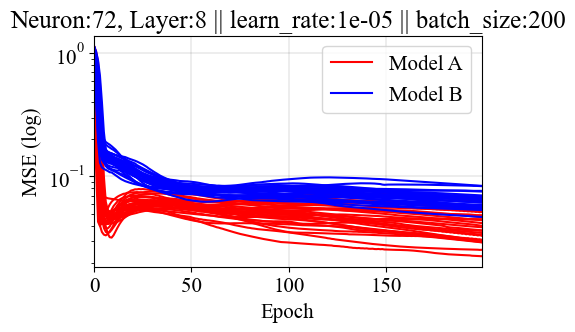

In [8]:
# plot the mse history   
from sklearn.metrics import mean_squared_error as mse
mse_pred_per_epoch_A = np.zeros([ensemble_num,epoch_total])
mse_pred_per_epoch_B = np.zeros([ensemble_num,epoch_total])

fig, axes = plt.subplots(1, 1, figsize=(5, 3))


neuron_this = num_neuron[0]
layer_this  = num_layer[0]

for i in range(ensemble_num): # number of folds
    for j in range(epoch_total):
        mse_pred_per_epoch_A[i,j] = mse(F_test_rec[0][:][:], predictions_A[i,neuron_this,layer_this].epoch_predictions[j][:,0])
    axes.semilogy(mse_pred_per_epoch_A[i,:], 'red', label='Model A' if i == 0 else None)
    axes.legend()
    
for i in range(ensemble_num): # number of folds
    for j in range(epoch_total):
        mse_pred_per_epoch_B[i,j] = mse(F_test_rec[0][:][:], predictions_B[i,neuron_this,layer_this].epoch_predictions[j][:,0])
    axes.semilogy(mse_pred_per_epoch_B[i,:], 'blue', label='Model B' if i == 0 else None)
    axes.legend()
    
    # find the index of the min value in an array
    aaa = mse_pred_per_epoch_A[i].tolist()
    min_value = min(aaa)
    min_value_index = aaa.index(min_value)
    # print('The index of the min value is: %d | The min value is: %f' % (min_value_index, min_value))
# axes[0].set_xlim([0,50])
axes.set_xlabel('Epoch')
axes.set_ylabel('MSE (log)')
axes.set_title(f'Neuron:{neuron_this}, Layer:{layer_this} || learn_rate:{learn_rate} || batch_size:{batch_how}')
axes.set_xmargin(0)
axes.grid(color='k', linestyle='-', linewidth=0.1)
# axes.text(165, 0.1, 'elu')

# axes.semilogy(history_all[num_neuron[0],num_layer[0]].history['loss'], label='train error')
axes.legend()

In [9]:
# this function finds the ensemble average of the epoch predictions and the std  history
# it returns the average result (array) and the std (array)
def ensemble_average(epoch_pred):
    sum_temp = np.zeros((len(epoch_pred[:,0]),len(epoch_pred[0,:])))
    sum_temp[:,0] = epoch_pred[:,0]
    std_hist = np.zeros((len(epoch_pred[0,:])))
    std_hist[0] = np.std(sum_temp[:,0])
    ensemble_averg = np.zeros((len(epoch_pred[:,0]),len(epoch_pred[0,:])))
    ensemble_averg[:,0] = epoch_pred[:,0]
    for i in range(len(epoch_pred[0,:])-1):
        sum_temp[:,i+1] = sum_temp[:,i] + epoch_pred[:,i+1]
        std_hist[i+1] = np.std(sum_temp[:,i+1]/(i+2))
        ensemble_averg[:,i+1] = sum_temp[:,i+1]/(i+2)
    return(std_hist, ensemble_averg)

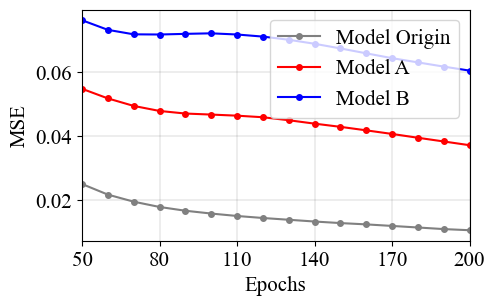

In [10]:
# this cell calcalute the mse of different ensembling average: 50,60,70,80,90,...200

# read the data with 16 sensors
data_16sensors = pd.read_csv('../data_16sensors.csv', header=None).to_numpy()

ensemble_use = np.arange(50,210,10)
mse_ensemble_use_A  = {} # dictionary, with keys and values
mse_ensemble_use_B  = {}
epoch_hist_use_A  = np.zeros([len(ensemble_use),len(F_test_rec[0]),ensemble_num]) # 16*10000*30: 16 to show the mse, 10000 samples, 30 repeats
epoch_hist_use_B  = np.zeros([len(ensemble_use),len(F_test_rec[0]),ensemble_num])
ensemble_avrg_use = {}
ensemble_std_use_A  = {}
ensemble_std_use_B  = {}
ensemble_avrg_use_A = {}
ensemble_avrg_use_B = {}

fig,ax = plt.subplots(figsize=(5,3))
for j in ensemble_use: # [50,60,70,80,90,...200]
    for i in range(ensemble_num): # repeat ensemble_num times with same hyperparameters
        epoch_hist_use_A[int(j/10-5),:,i] = predictions_A[i,neuron_this,layer_this].epoch_predictions[j-1][:,0]
        epoch_hist_use_B[int(j/10-5),:,i] = predictions_B[i,neuron_this,layer_this].epoch_predictions[j-1][:,0]
        
    (ensemble_std_use_A[j], ensemble_avrg_use_A[j]) = ensemble_average(epoch_hist_use_A[int(j/10-5)])
    (ensemble_std_use_B[j], ensemble_avrg_use_B[j]) = ensemble_average(epoch_hist_use_B[int(j/10-5)])
    
    mse_ensemble_use_A[j] = mse(ensemble_avrg_use_A[j][:,-1], F_test_rec[0][:,:])
    mse_ensemble_use_B[j] = mse(ensemble_avrg_use_B[j][:,-1], F_test_rec[0][:,:])

ax.plot(mse_ensemble_use_A.keys(),data_16sensors[:,1],
        color='gray', linewidth=1.5,marker='.',markersize=8, label='Model Origin')
ax.plot(mse_ensemble_use_A.keys(),mse_ensemble_use_A.values(),
        color='red', linewidth=1.5,marker='.',markersize=8, label='Model A')
ax.plot(mse_ensemble_use_B.keys(),mse_ensemble_use_B.values(),
        color='blue', linewidth=1.5,marker='.',markersize=8, label='Model B')
ax.set_xlim(50,200)
ax.set_xticks(np.arange(50,210,30).tolist())
# ax_use.set_ylim(0.010,0.026)
ax.grid(color='k', linestyle='-', linewidth=0.1)
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')
ax.legend()
# fig.savefig('ensemble_error_Filter_neuron%d_layer%d.png' % (neuron_this,layer_this), bbox_inches='tight', dpi=300)
# fig.savefig('ensemble_error_Filter_neuron%d_layer%d.svg' % (neuron_this,layer_this), bbox_inches='tight')

# Plot the results

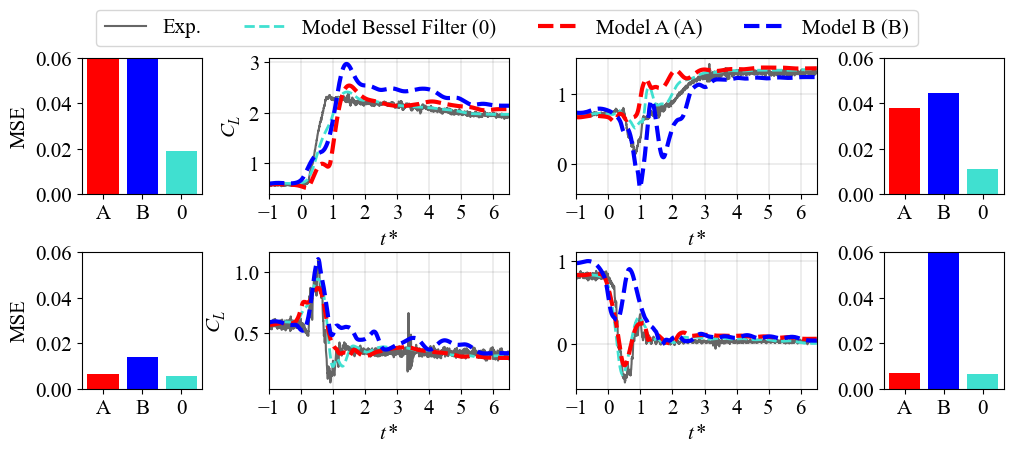

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.metrics import mean_squared_error as mse
import pickle

repeat_num = 200 # repeated number: 50 100

T = 0.3 # period is 0.3s
f = 1000 # frequency is 1000Hz
t_star = (np.arange(0,10000)-500) / f / T 

ensemble_avrg_use_bessel_filter = pickle.load(open("../ensemble_avrg_use_bessel_filter.dat", "rb"))

# Create the main figure
fig = plt.figure(figsize=(10, 4))

# Define the width ratios for the columns
width_ratios = [1, 2, 2, 1]

# Create a GridSpec layout with 2 rows and 4 columns, and set the width ratios
gs = GridSpec(2, 4, figure=fig, width_ratios=width_ratios)
k = 0 # for count only
mse_list = []
# Loop through the 2x2 subfigures and create two subsubfigures in each
for i in range(2):
    for j in range(2):
        if j ==0:
            # Create subsubfigure 1 (thinner)
            ax1 = fig.add_subplot(gs[i, 2*j])
            mse_model_A = mse(F_test_rec[0][2500*k:2500*(k+1),:], 
                              ensemble_avrg_use_A[repeat_num][2500*k:2500*(k+1),-1])
            mse_model_B = mse(F_test_rec[0][2500*k:2500*(k+1),:], 
                              ensemble_avrg_use_B[repeat_num][2500*k:2500*(k+1),-1])
            mse_model_bessel = mse(F_test_rec[0][2500*k:2500*(k+1),:], 
                                   ensemble_avrg_use_bessel_filter[repeat_num][2500*k:2500*(k+1),-1])

            mse_list.append([mse_model_A, mse_model_B, mse_model_bessel])

            ax1.bar(np.arange(3), [mse_model_A, mse_model_B, mse_model_bessel], color=['red', 'blue', 'turquoise'])
            ax1.set_xticks(np.arange(3))
            ax1.set_xticklabels(['A', 'B', '0'])
            ax1.set_ylabel('MSE')
            # ax1.set_ylim(0, max(mse_model_A, mse_model_B, mse_model_bessel) * 1.1)
            ax1.set_ylim(0, 0.06)

            # Create subsubfigure 2
            ax2 = fig.add_subplot(gs[i, 2*j + 1])
            ax2.plot(t_star[0:2500], F_test_rec[0][2500*k:2500*(k+1),:],label='Exp.',color='#666666', linewidth=1.5)
            ax2.plot(t_star[0:2500], ensemble_avrg_use_bessel_filter[repeat_num][2500*k:2500*(k+1),-1], 
                     color='turquoise', linewidth=2, linestyle='--', label='Model Bessel Filter (0)')
            ax2.plot(t_star[0:2500], ensemble_avrg_use_A[repeat_num][2500*k:2500*(k+1),-1],label='Model A (A)', 
                     color='red', linewidth=3, linestyle='--')
            ax2.plot(t_star[0:2500], ensemble_avrg_use_B[repeat_num][2500*k:2500*(k+1),-1],label='Model B (B)', 
                     color='blue', linewidth=3, linestyle='--')
            ax2.grid(color='k', linestyle='-', linewidth=0.1)
            ax2.set_xticks(np.arange(-1,8))
            ax2.set_xlim(-1,6.5)
            ax2.margins(x=0)
            ax2.set_xlabel('$t*$')
            ax2.set_ylabel('$C_{L}$')
        else:
            # Create subsubfigure 1 (thinner)
            ax1 = fig.add_subplot(gs[i, 2*j])
            ax1.plot(t_star[0:2500], F_test_rec[0][2500*k:2500*(k+1),:],label='Exp.',color='#666666', linewidth=1.5)
            ax1.plot(t_star[0:2500], ensemble_avrg_use_bessel_filter[repeat_num][2500*k:2500*(k+1),-1], 
                     color='turquoise', linewidth=2, linestyle='--', label='Model Bessel Filter (0)')
            ax1.plot(t_star[0:2500], ensemble_avrg_use_A[repeat_num][2500*k:2500*(k+1),-1],label='Model A (A)', 
                     color='red', linewidth=3, linestyle='--')
            ax1.plot(t_star[0:2500], ensemble_avrg_use_B[repeat_num][2500*k:2500*(k+1),-1],label='Model B (B)', 
                     color='blue', linewidth=3, linestyle='--')
            ax1.grid(color='k', linestyle='-', linewidth=0.1)
            ax1.set_xticks(np.arange(-1,8))
            ax1.set_xlim(-1,6.5)
            ax1.margins(x=0)
            ax1.set_xlabel('$t*$')
            # ax1.set_ylabel('$C_{L}$')

            # Create subsubfigure 2
            ax2 = fig.add_subplot(gs[i, 2*j+1])
            mse_model_A = mse(F_test_rec[0][2500*k:2500*(k+1),:], 
                              ensemble_avrg_use_A[repeat_num][2500*k:2500*(k+1),-1])
            mse_model_B = mse(F_test_rec[0][2500*k:2500*(k+1),:], 
                              ensemble_avrg_use_B[repeat_num][2500*k:2500*(k+1),-1])
            mse_model_bessel = mse(F_test_rec[0][2500*k:2500*(k+1),:], 
                                   ensemble_avrg_use_bessel_filter[repeat_num][2500*k:2500*(k+1),-1])

            mse_list.append([mse_model_A, mse_model_B, mse_model_bessel])

            ax2.bar(np.arange(3), [mse_model_A, mse_model_B, mse_model_bessel], color=['red', 'blue', 'turquoise'])
            ax2.set_xticks(np.arange(3))
            ax2.set_xticklabels(['A', 'B', '0'])
            # ax2.set_ylabel('MSE')
            ax2.set_ylim(0, max(mse_model_A, mse_model_B, mse_model_bessel) * 1.1)
            ax2.set_ylim(0, 0.06)
            
        k = k+1

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=4)

# Adjust the layout for better spacing between subfigures
plt.tight_layout(pad=0.15)
plt.show()
